## Greenland Grid System

Here I'm going to look into setting up a grid to use for the dHdt project.  I'm going to investigate how many laser shots I get in each cell depending on the grid spacing.  The grid will be in the EPSG:3413 (N. Polar Sterographic) projection. As boundaries for Greenland I'm going to use the same bounds I used when setting up the `gla06_034_grn` table, -90 - 5 longitude and 55 to 85 latitude.

Having experimented with both the ICESAT data and the ATM data, I may need to set up different grids depending on the data density.  Let's start by using a grid of 20km x 20km which is probably too coarse but which should give at least some laser shots for each grid cell.

In [60]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from osgeo import osr, gdal, ogr


# try to display same using basemap
from mpl_toolkits.basemap import Basemap

# GIMP bounding box from gdalinfo on 180m tiff file
gimp_bbox = (-639985.000, -3355565.000, 855815.000, -655565.000)
psx_ll, psy_ll, psx_ur, psy_ur = gimp_bbox

# GIMP bounding box rounded to 1km
gimp_bbox = (-640000.000, -3356000.000, 856000.000, -656000.000)
psx_ll, psy_ll, psx_ur, psy_ur = gimp_bbox

# convert these to lon-lat
sr_ps = osr.SpatialReference()
sr_ps.ImportFromEPSG(3413)
sr_wgs84 = osr.SpatialReference()
sr_wgs84.ImportFromEPSG(4326)

# create coordinate transformation
ps2wgs84 = osr.CoordinateTransformation(sr_ps, sr_wgs84)


In [61]:
# transform corners

# lower-left
pt_ll = ogr.Geometry(ogr.wkbPoint)
pt_ll.AddPoint(psx_ll, psy_ll)
pt_ll.Transform(ps2wgs84)
lon_ll = pt_ll.GetX()
lat_ll = pt_ll.GetY()

# upper-right
pt_ur = ogr.Geometry(ogr.wkbPoint)
pt_ur.AddPoint(psx_ur, psy_ur)
pt_ur.Transform(ps2wgs84)
lon_ur = pt_ur.GetX()
lat_ur = pt_ur.GetY()
print lon_ur, lat_ur

7.53506372333 80.0683861577


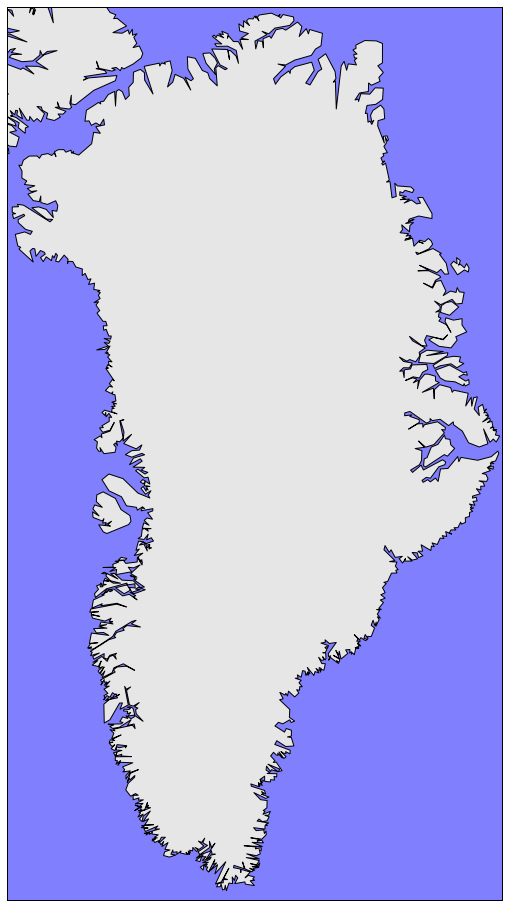

In [62]:
# make a simple map of Greenland
fig = plt.figure(figsize=[16,16])
m = Basemap(projection='stere',lat_0=90.,lon_0=-45.,lat_ts=70.,ellps='WGS84',
              resolution='l',
              llcrnrlon=lon_ll, llcrnrlat=lat_ll, 
              urcrnrlon=lon_ur, urcrnrlat=lat_ur)

m.drawmapboundary(fill_color=[.5, .5, 1.0])
m.fillcontinents(color=[.9, .9, .9], lake_color='w',zorder=0)
m.drawcoastlines(color='k')


plt.show()

In [69]:
# set up grid of cell centers in polar stereographic coords

gridsize = 10000.
xvals = np.arange(psx_ll + gridsize/2., psx_ur - gridsize/2., grid_size)
yvals = np.arange(psy_ll + gridsize/2., psy_ur - gridsize/2., grid_size)
print len(xvals), len(yvals)

xv, yv = np.meshgrid(xvals, yvals)
xvals = np.ravel(xv)
yvals = np.ravel(yv)
print xvals[0], xvals[1]

149 269
-635000.0 -625000.0


In [70]:
# because of the screwy way basemap handles coordinates and bounding
# boxes (for stereographic projections at least) I have to convert
# grid coordinates to map coordinates
sr_map = osr.SpatialReference()
sr_map.ImportFromProj4(m.proj4string)
sr_ps = osr.SpatialReference()
sr_ps.ImportFromEPSG(3413)
mapct = osr.CoordinateTransformation(sr_ps, sr_map)
print m.proj4string

# look at corners using maps 
x0 = 640089.597677
y0 = 3355467.17938
lon0, lat0 = m(0., 0., inverse=True)
print lon0, lat0

+a=6378137.0 +b=6356752.31425 +lat_ts=70.0 +lon_0=-45.0 +proj=stere +x_0=640000.0 +units=m +y_0=3356000.0 +lat_0=90.0 
-55.7968496565 59.195641458


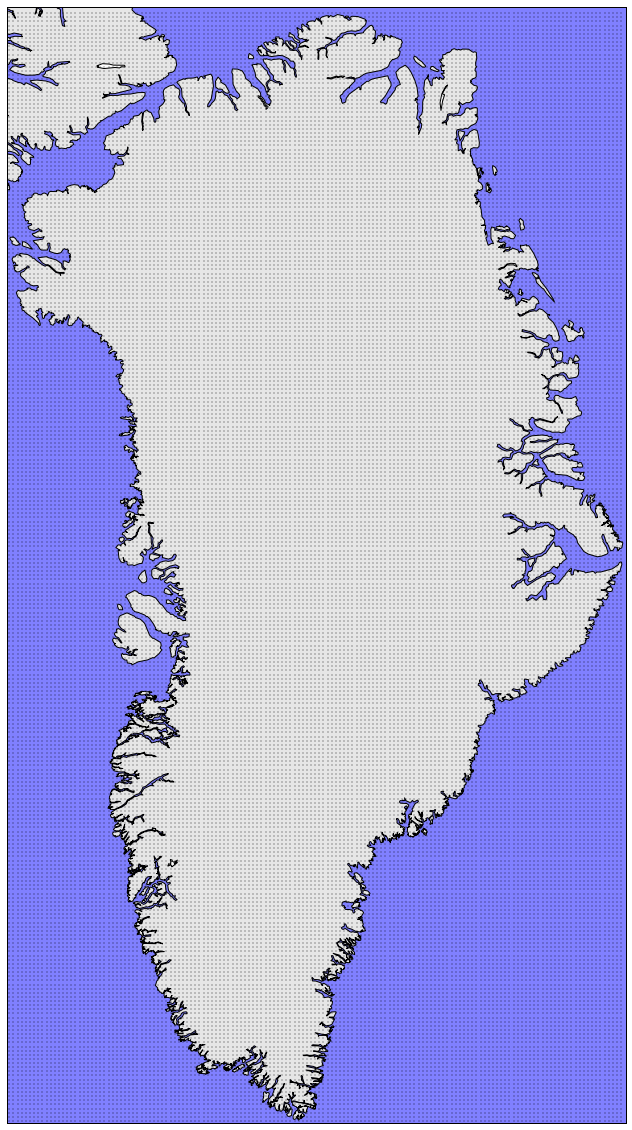

In [71]:
x0 = 640089.597677
y0 = 3355467.17938
map_xvals = xvals + x0
map_yvals = yvals + y0

fig = plt.figure(figsize=[20,20])
m = Basemap(projection='stere',lat_0=90.,lon_0=-45.,lat_ts=70.,ellps='WGS84',
              resolution='i',
              llcrnrlon=lon_ll, llcrnrlat=lat_ll, 
              urcrnrlon=lon_ur, urcrnrlat=lat_ur)

m.drawmapboundary(fill_color=[.5, .5, 1.0])
m.fillcontinents(color=[.9, .9, .9], lake_color='w',zorder=0)
# m.bluemarble()
m.drawcoastlines(color='k')
m.plot(map_xvals, map_yvals,'k.',markersize=.8)

plt.show()

Draw a box around Jakobshavn Fjord for subsetting the data for Mark F.

-52.0 68.2
+a=6378137.0 +b=6356752.31425 +lat_ts=70.0 +lon_0=-45.0 +proj=stere +x_0=291181.459513 +units=m +y_0=2371482.67968 +lat_0=90.0 
-4.41446900368e-07 -7.28294253349e-07


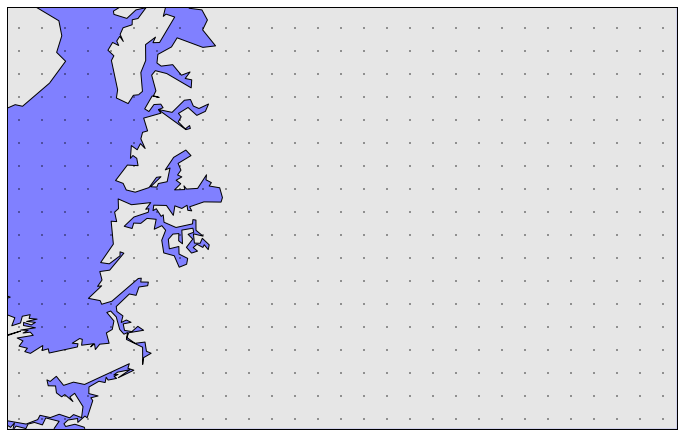

In [75]:
jak_lon_ll = -52.
jak_lat_ll = 68.2
jak_lon_ur = -45.
jak_lat_ur = 70.

fig = plt.figure(figsize=[12,8])
m = Basemap(projection='stere',lat_0=90.,lon_0=-45.,lat_ts=70.,ellps='WGS84',
              resolution='i',
              llcrnrlon=jak_lon_ll, llcrnrlat=jak_lat_ll, 
              urcrnrlon=jak_lon_ur, urcrnrlat=jak_lat_ur)

m.drawmapboundary(fill_color=[.5, .5, 1.0])
m.fillcontinents(color=[.9, .9, .9], lake_color='w',zorder=0)
m.drawcoastlines(color='k')
# m.bluemarble()
m.plot(map_xvals, map_yvals,'k.',markersize=1.5)


lon0, lat0 = m(0., 0., inverse=True)
print lon0, lat0
print m.proj4string




In [77]:
# convert the box corners to ps
jak_psx_ll = -291181.459513
jak_psy_ll = -2371482.67968
psx_0, psy_0 = m(jak_lon_ur, jak_lat_ur)
print psx_0, psy_0

# How do I find the grid points in this box?  I could make a shapefile
# from the grid points in the entire GIMP box

291181.459513 183555.030402
